Uses an interface into IPOPT to solve sub-problems in iterative convex optimization. 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')

from Utils import ipopt  
from EntryGuidance import Mesh 

In [59]:
solver = ipopt.Solver()

mesh = Mesh.Mesh(t0=0, tf=10, orders=[4]*20)    
N = len(mesh.times)

x0 = [3,0]
A0 = np.array([[0,1],[-1,0]])
B0 = np.array([0,1])

guess = np.array([np.linspace(x0[0], 0, N), np.zeros((N,))]).T
guess_u = np.zeros(N,)
print(guess.shape)

X0 = solver.create_vars(guess)
U0 = solver.create_vars(guess_u)

Ai = [A0]*N
Bi = [B0]*N

X = mesh.chunk(X0)
U = mesh.chunk(U0)
A = mesh.chunk(Ai)
B = mesh.chunk(Bi)

# End point constraints
solver.Equation(X0[0,0]==x0[0])
solver.Equation(X0[0,1]==x0[1])

solver.Equation(X0[-1,0]==0)
solver.Equation(X0[-1,1]==0)

L = []
for a, x, b, u, d, w in zip(A,X,B,U,mesh.diffs, mesh.weights): # Iterate over mesh segments 
    solver.StateSpace(a, x, b, u, d) # linear dynamic constraints 
    
    # Running cost computation 
    lagrange = u**2
    la_var = solver.model.Var(0.)
    solver.Equation(la_var == w.dot(lagrange)) # The use of these intermediate variables allows the obj to be written as a small sum. This avoids the 15k character limit. 
    L.append(la_var)
    
    # Path constraints:
    [solver.Equation(-2.6-1.3*x1+x2 <= 0) for (x1,x2) in x]
    [solver.Equation(x2 >= -2.) for (x1,x2) in x]

#     [solver.Equation(ui**2 <= 9) for ui in u] # control limited to 3 

solver.Obj(sum(L))
# solver.model.Solver = 0 # for optimizer comparison
solver.solve()

x_sol = solver.get_values(X0)
u_sol = solver.get_values(U0)

(81, 2)
 ----------------------------------------------------------------
 APMonitor, Version 0.8.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  463
   Intermediates:  0
   Connections  :  0
   Equations    :  425
   Residuals    :  425
 
 Number of state variables:    463
 Number of total equations: -  424
 Number of slack variables: -  200
 ---------------------------------------
 Degrees of freedom       :    -161
 
 * Warning: DOF <= 0
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code u

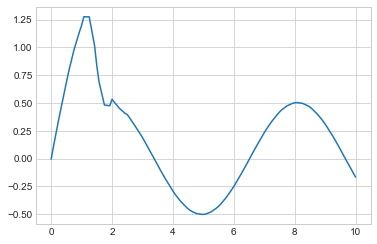

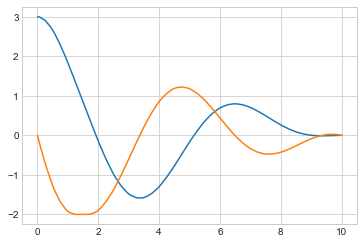

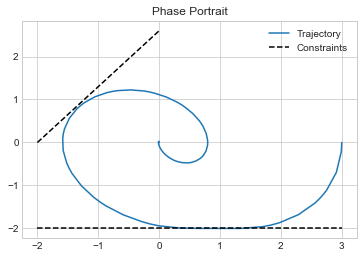

In [60]:
plt.figure()
plt.plot(mesh.times, u_sol)

plt.figure()
plt.plot(mesh.times, x_sol)

plt.figure()
plt.title('Phase Portrait')
plt.plot(x_sol.T[0],x_sol.T[1], label='Trajectory')

x1 = np.linspace(-2,0)
x2 = 1.3*x1 + 2.6
plt.plot(x1,x2,'k--', label='Constraints')

x1 = np.linspace(-2,3)
plt.plot(x1, -2.*np.ones_like(x1),'k--')
plt.legend()